In [9]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [10]:
df = pd.read_csv('vaccination_tweets.csv')

In [11]:
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [13]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [14]:
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1)
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [15]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")

Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [16]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


In [18]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [ ]:
text_df.text = text_df['text'].apply(data_processing)

In [ ]:
text_df = text_df.drop_duplicates('text')

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [ ]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))

In [47]:
text_df.head()

,text,polarity
0,Same folks said daikon paste could treat a cyt...,0.00
1,While the world has been on the wrong side of ...,-0.50
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0.00
3,"Facts are immutable, Senator, even when you're...",-0.05
4,Explain to me again why we need a vaccine @Bor...,0.00


In [48]:
print(text_df['text'].iloc[0],"\n")
print(text_df['text'].iloc[1],"\n")
print(text_df['text'].iloc[2],"\n")
print(text_df['text'].iloc[3],"\n")
print(text_df['text'].iloc[4],"\n")


Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF 

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm 

#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P 

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4 

Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq 



In [49]:
text_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      11020 non-null  object 
 1   polarity  11020 non-null  float64
dtypes: float64(1), object(1)
memory usage: 172.3+ KB


In [ ]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
text_df['polarity'] = text_df['text'].apply(polarity)

In [50]:
text_df.head(10)



,text,polarity
0,Same folks said daikon paste could treat a cyt...,0.000
1,While the world has been on the wrong side of ...,-0.500
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0.000
3,"Facts are immutable, Senator, even when you're...",-0.050
4,Explain to me again why we need a vaccine @Bor...,0.000
5,Does anyone have any useful advice/guidance fo...,0.400
6,it is a bit sad to claim the fame for success ...,-0.100
7,There have not been many bright days in 2020 b...,0.675
8,Covid vaccine; You getting it?\n\n #CovidVacci...,0.000
9,#CovidVaccine \n\nStates will start getting #C...,0.000


In [53]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"


In [54]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)

In [55]:
text_df.head()

,text,polarity,sentiment
0,Same folks said daikon paste could treat a cyt...,0.00,Neutral
1,While the world has been on the wrong side of ...,-0.50,Negative
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0.00,Neutral
3,"Facts are immutable, Senator, even when you're...",-0.05,Negative
4,Explain to me again why we need a vaccine @Bor...,0.00,Neutral


<AxesSubplot:xlabel='sentiment', ylabel='count'>

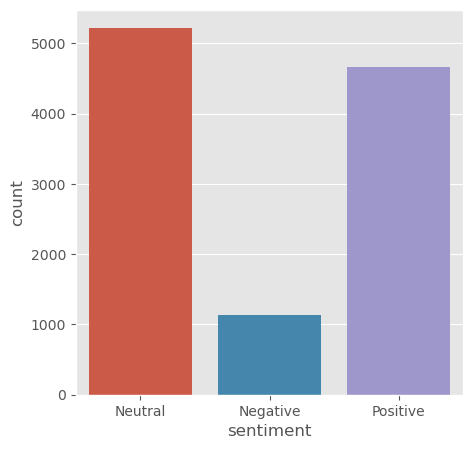

In [56]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

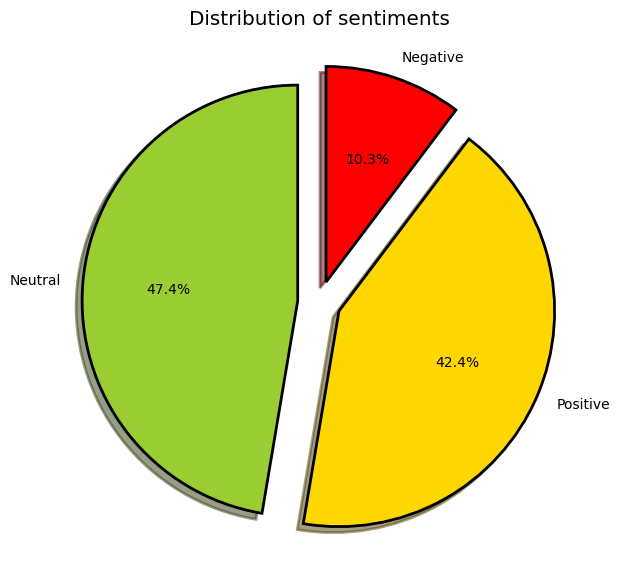

In [57]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [58]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,polarity,sentiment
4788,Very happy to have been given the 1st dose of ...,1.0,Positive
8776,Made in Germany always the best 🇩🇪\n\n#ger #P...,1.0,Positive
8825,I’m so happy i’m vaccinated 🤍 because vaccines...,1.0,Positive
1055,Already vaccinated or getting vaccine soon? Pl...,1.0,Positive
2156,Oh happy day! 🥰 #PfizerBioNTech #RibosomeAtWor...,1.0,Positive


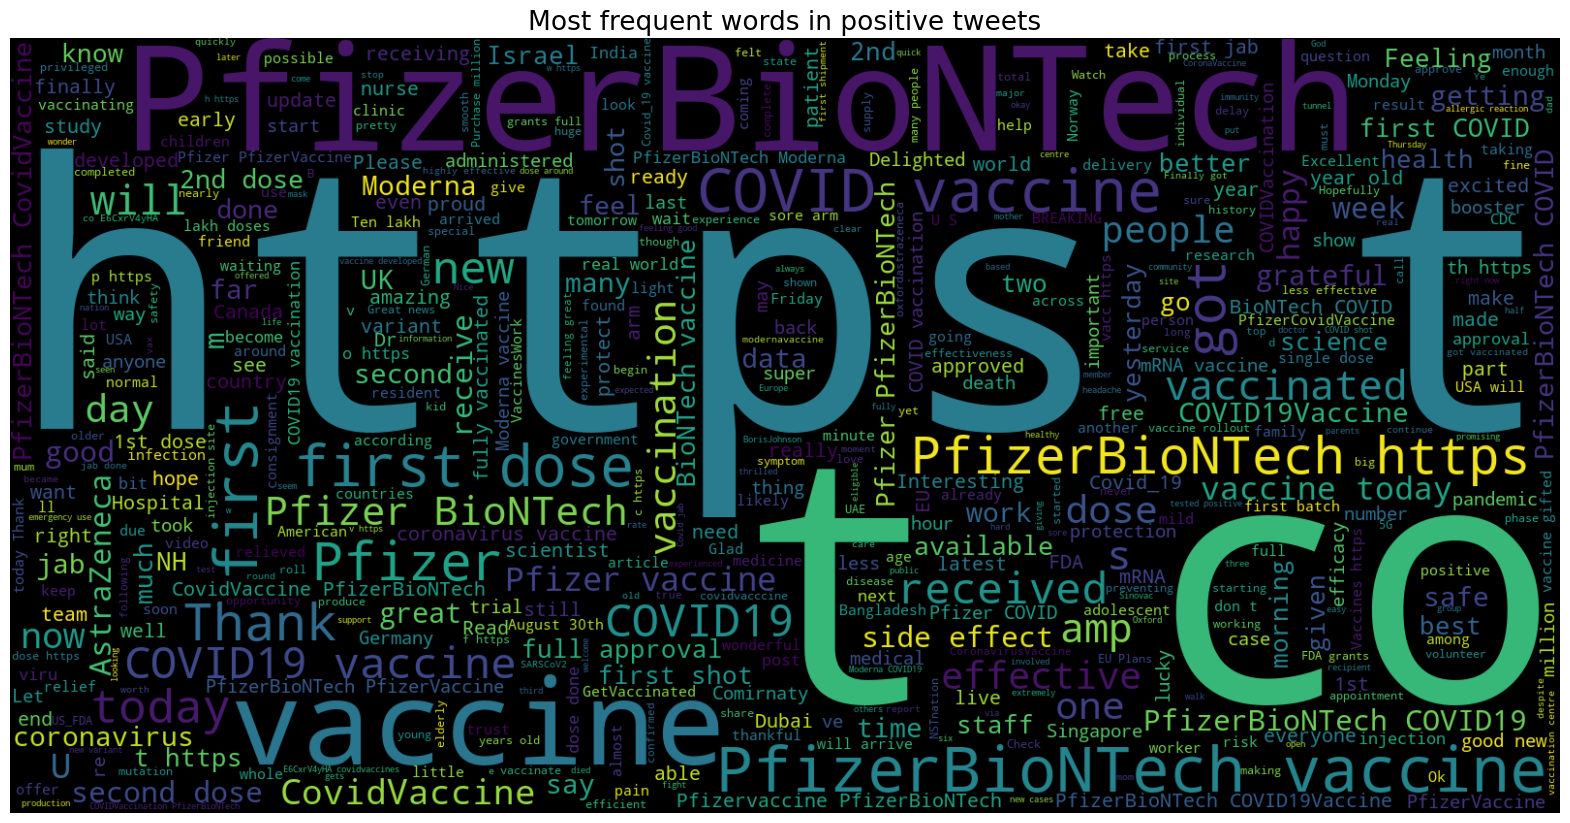

In [59]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [60]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,polarity,sentiment
3940,"Vaccines can have side effects, but they are e...",-9.251859e-18,Negative
8172,"This should make ""vaccination-center"" life muc...",-4.166667e-03,Negative
7157,@Nas_k27 My second dose due end of next month ...,-6.250000e-03,Negative
2907,In 2015 we were worried about absence of mRNA ...,-6.250000e-03,Negative
5649,My arm is a little sore 😔 \nBut so far no othe...,-8.333333e-03,Negative


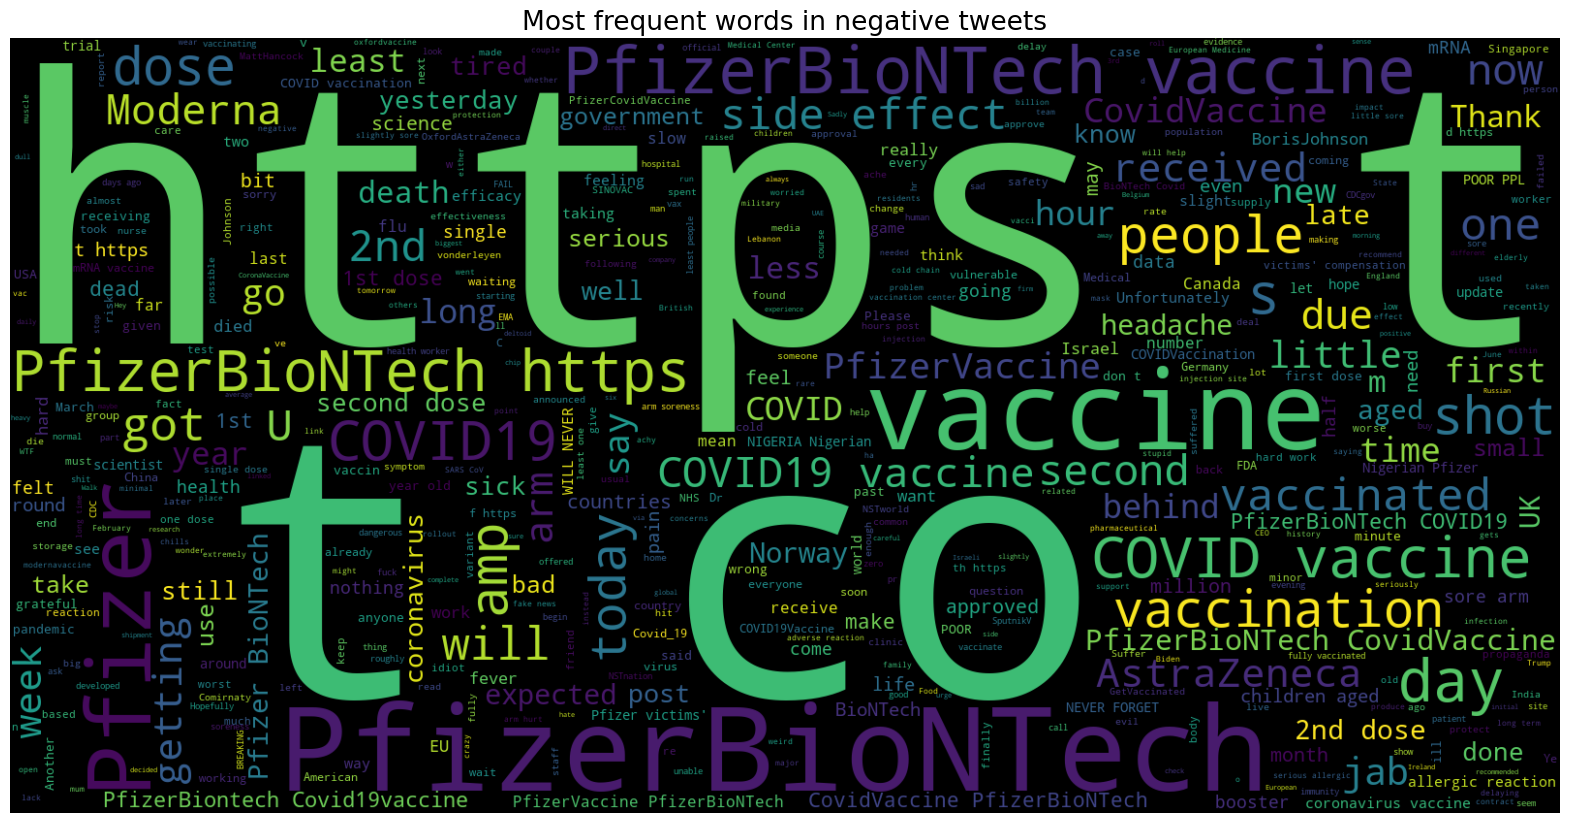

In [61]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [62]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,text,polarity,sentiment
0,Same folks said daikon paste could treat a cyt...,0.0,Neutral
7555,@CallMeJulius I got mine two weeks ago (#Pfize...,0.0,Neutral
7596,"#NSTnation A total of 25,770 cases or 3.5 per ...",0.0,Neutral
7595,#PfizerProud 👇🏻 of our leadership - #PFECollea...,0.0,Neutral
7594,Got that stabby stab of #pfizer in me today! #...,0.0,Neutral


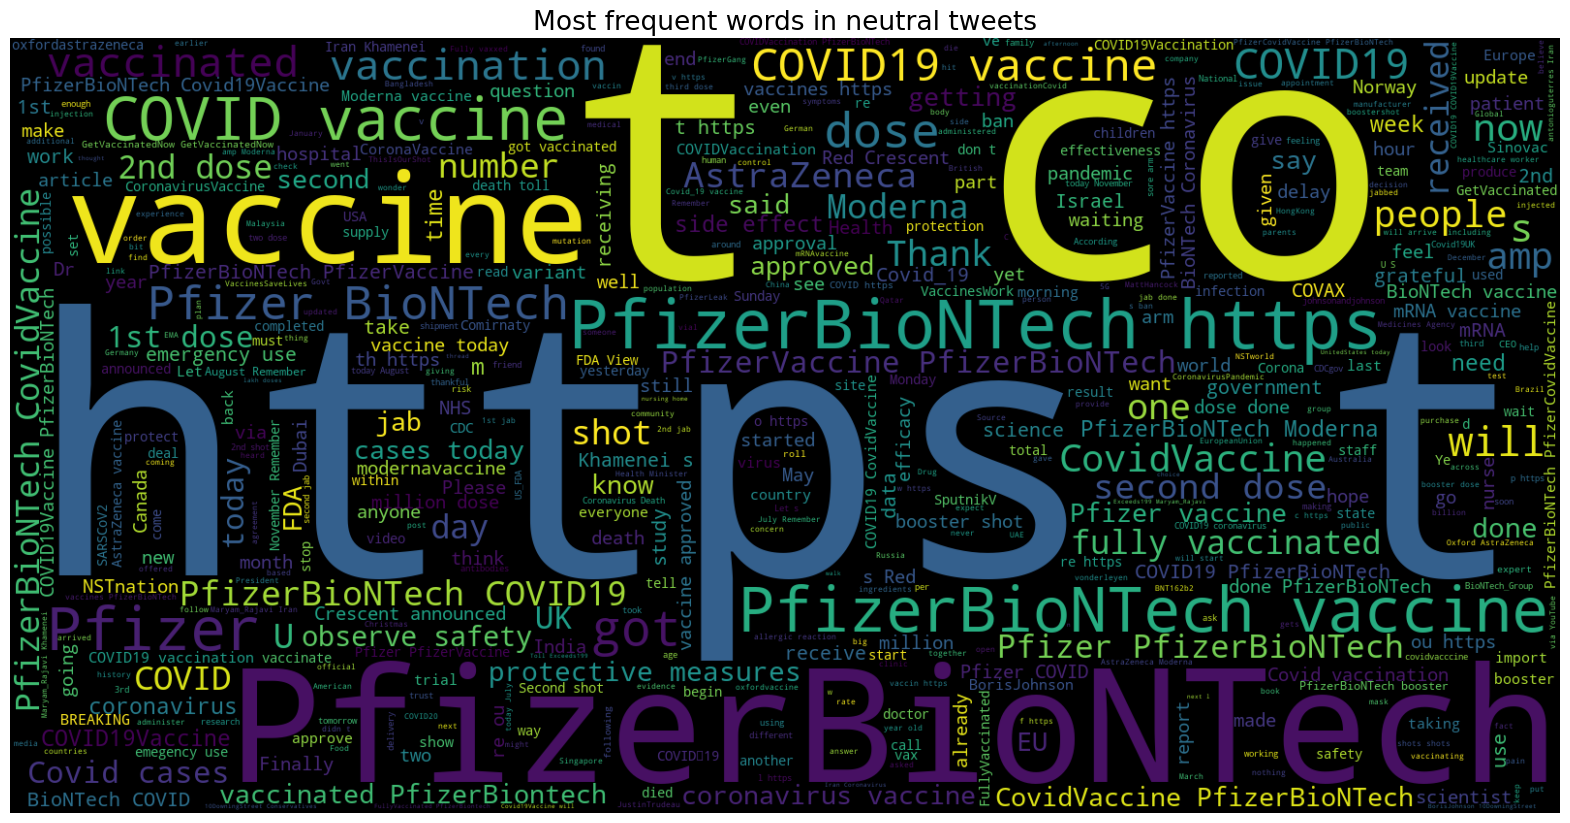

In [63]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [64]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [71]:
feature_names = vect.get_feature_names()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 113986

First 20 features:
 ['00', '00 000', '00 am', '00 doses', '00 hkt', '00 https', '00 on', '00 tonight', '000', '000 987', '000 advers', '000 adverse', '000 albertans', '000 americans', '000 and', '000 australians', '000 citizens', '000 coronavirus', '000 covid19', '000 covidbrazil']


C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [68]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (8816, 113986)
Size of y_train: (8816,)
Size of x_test: (2204, 113986)
Size of y_test: (2204,)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [69]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 82.53%


C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [72]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 66 126  36]
 [ 10 979  35]
 [ 12 166 774]]


              precision    recall  f1-score   support

    Negative       0.75      0.29      0.42       228
     Neutral       0.77      0.96      0.85      1024
    Positive       0.92      0.81      0.86       952

    accuracy                           0.83      2204
   macro avg       0.81      0.69      0.71      2204
weighted avg       0.83      0.83      0.81      2204



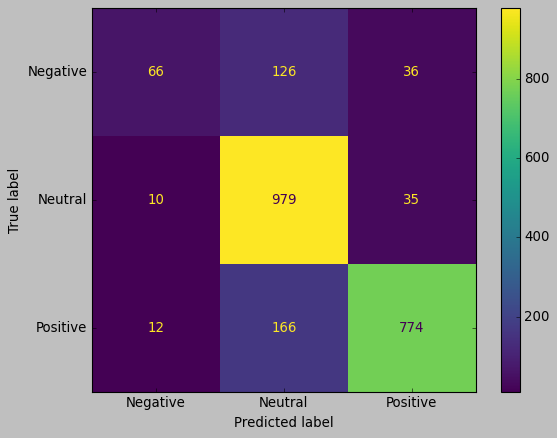

In [73]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [77]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [79]:
y_pred = grid.predict(x_test)

In [80]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 83.39%


In [81]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 74 118  36]
 [ 11 979  34]
 [ 13 154 785]]


              precision    recall  f1-score   support

    Negative       0.76      0.32      0.45       228
     Neutral       0.78      0.96      0.86      1024
    Positive       0.92      0.82      0.87       952

    accuracy                           0.83      2204
   macro avg       0.82      0.70      0.73      2204
weighted avg       0.84      0.83      0.82      2204



In [82]:
from sklearn.svm import LinearSVC

In [83]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [84]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 84.03%


In [85]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 81 112  35]
 [ 15 978  31]
 [ 17 142 793]]


              precision    recall  f1-score   support

    Negative       0.72      0.36      0.48       228
     Neutral       0.79      0.96      0.87      1024
    Positive       0.92      0.83      0.88       952

    accuracy                           0.84      2204
   macro avg       0.81      0.71      0.74      2204
weighted avg       0.84      0.84      0.83      2204



In [86]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\user\anaconda3\anacondaaa\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [87]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 10}


In [88]:
y_pred = grid.predict(x_test)

In [89]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 84.07%


In [90]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 82 110  36]
 [ 15 979  30]
 [ 20 140 792]]


              precision    recall  f1-score   support

    Negative       0.70      0.36      0.48       228
     Neutral       0.80      0.96      0.87      1024
    Positive       0.92      0.83      0.88       952

    accuracy                           0.84      2204
   macro avg       0.81      0.72      0.74      2204
weighted avg       0.84      0.84      0.83      2204

